### Imports

In [17]:
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import time

### Obtain and Prepare Data

In [18]:
start = datetime.strptime('2020-01-02','%Y-%m-%d')
end = datetime.strptime('2022-02-28','%Y-%m-%d')

df = data.DataReader('BTC-USD',start=start, end=end, data_source='yahoo')
df = df['Close']

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [20]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:]

In [21]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [22]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [23]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Build and Train LSTM

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [26]:
start= time.time()
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
end=time.time()

Epoch 1/100
7/7 [==============================] - 5s 248ms/step - loss: 0.0899 - val_loss: 0.0678
Epoch 2/100
7/7 [==============================] - 1s 117ms/step - loss: 0.0211 - val_loss: 0.0398
Epoch 3/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0158 - val_loss: 0.0065
Epoch 4/100
7/7 [==============================] - 1s 113ms/step - loss: 0.0073 - val_loss: 0.0094
Epoch 5/100
7/7 [==============================] - 1s 114ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 6/100
7/7 [==============================] - 1s 115ms/step - loss: 0.0040 - val_loss: 0.0112
Epoch 7/100
7/7 [==============================] - 1s 111ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 8/100
7/7 [==============================] - 1s 111ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 9/100
7/7 [==============================] - 1s 117ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 10/100
7/7 [==============================] - 1s 112ms/step - loss: 0.0035 - val_loss: 0.0059
Epoch 11/

Epoch 83/100
7/7 [==============================] - 1s 119ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 84/100
7/7 [==============================] - 1s 113ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 85/100
7/7 [==============================] - 1s 117ms/step - loss: 9.9015e-04 - val_loss: 0.0027
Epoch 86/100
7/7 [==============================] - 1s 116ms/step - loss: 9.9292e-04 - val_loss: 0.0072
Epoch 87/100
7/7 [==============================] - 1s 115ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 88/100
7/7 [==============================] - 1s 115ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 89/100
7/7 [==============================] - 1s 114ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 90/100
7/7 [==============================] - 1s 120ms/step - loss: 9.6858e-04 - val_loss: 0.0026
Epoch 91/100
7/7 [==============================] - 1s 114ms/step - loss: 9.4406e-04 - val_loss: 0.0032
Epoch 92/100
7/7 [==============================] - 1s 112ms/step - loss: 0.0011 - v

### Make Predictions

In [27]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

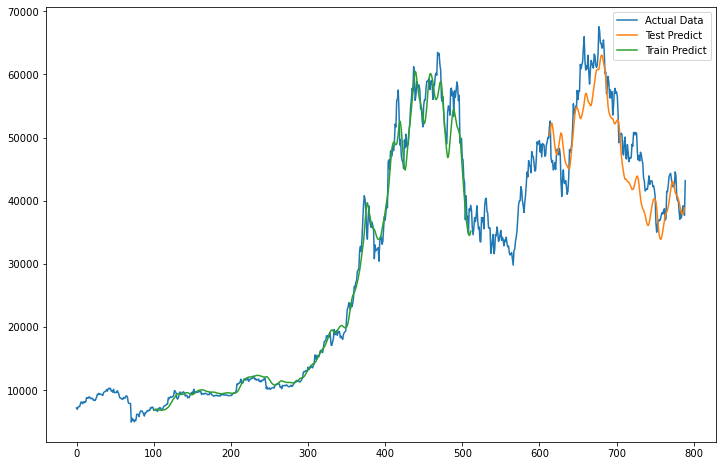

In [28]:
look_back=time_step
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.legend(['Actual Data','Test Predict','Train Predict'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

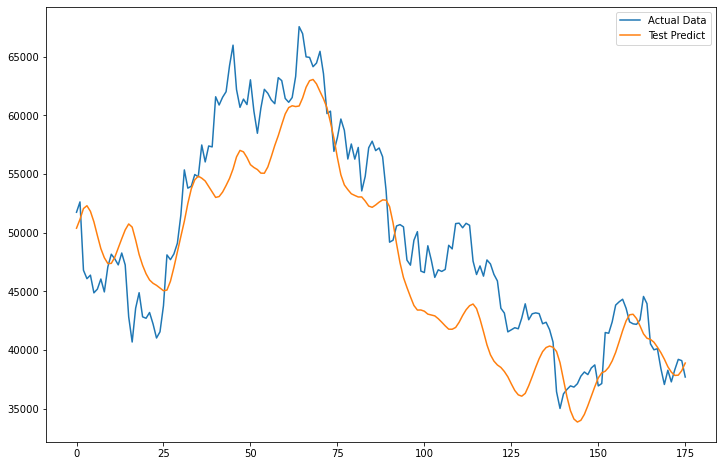

In [29]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.legend(['Actual Data','Test Predict'])
plt.show

### Evaluation

In [30]:
from sklearn.metrics import mean_squared_error
test_predict=model.predict(X_test)
print('MSE:',mean_squared_error(y_test, test_predict))

MSE: 0.004704434244992092


In [33]:
print('Volatility:',np.log(df/df.shift()).std()*252**0.5)

Volatility: 0.6469415182201617


In [32]:
print('Time taken for training in seconds:',end-start)

Time taken for training in seconds: 85.54842686653137
